In [1]:
import pandas as pd
from pathlib import Path

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from sklearn.model_selection import train_test_split
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss, mean_squared_error)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)


In [3]:
# load the train data
train =  pd.read_csv('../input/new-york-city-taxi-fare-prediction/train.csv', nrows = 100_000)
train.shape


(100000, 8)

In [4]:
# remove all missing values from train data
train.dropna(inplace=True)

# drop all rows with pickup_latitude  90
train = train.drop(((train[train['pickup_latitude']90])).index, axis=0)
train = train.drop(((train[train['pickup_latitude']>90])).index, axis=0)

# drop all rows with pickup_longitude  180
train = train.drop(((train[train['pickup_longitude']180])).index, axis=0)
train = train.drop(((train[train['pickup_longitude']>180])).index, axis=0)

# drop all rows with dropoff_latitude  90
train = train.drop(((train[train['dropoff_latitude']90])).index, axis=0)
train = train.drop(((train[train['dropoff_latitude']>90])).index, axis=0)

# drop all rows with dropoff_longitude  180
train = train.drop(((train[train['dropoff_longitude']180])).index, axis=0)
train = train.drop(((train[train['dropoff_longitude']>180])).index, axis=0)

# drop all rows with fare_amount  100
train = train.drop(((train[train['fare_amount']>100])).index, axis=0)
train = train.drop(((train[train['fare_amount']0.5])).index, axis=0)

# drop all rows with passenger_count 
train = train.drop(((train[train['passenger_count']==0])).index, axis=0)
train = train.drop(train[train['passenger_count']>10].index, axis = 0)

train.shape


SyntaxError: invalid syntax. Perhaps you forgot a comma? (3217336766.py, line 5)

In [5]:
# A function to calculate the distance:
# Haversine distance calculation
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth specified in radians.
    """
    # Radius of the Earth in km
    R = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c

    return distance


In [6]:
# Feature Engineering for the training set
# Calculate distance using Haversine formula
train['distance'] = haversine_distance(train['pickup_latitude'], train['pickup_longitude'], train['dropoff_latitude'], train['dropoff_longitude'])
# Convert pickup datetime to datetime object
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
# Extract features from pickup datetime
train['day_of_week'] = train['pickup_datetime'].dt.dayofweek
train['month'] = train['pickup_datetime'].dt.month
train['hour'] = train['pickup_datetime'].dt.hour

train.shape


(100000, 12)

In [7]:
# drop all rows with distance > 28 and distance = 0
train = train.drop(((train[train['distance']>28])).index, axis=0)
train = train.drop(((train[train['distance']==0])).index, axis=0)

train.shape


(96823, 12)

In [8]:
# Define features and target
X = train[['passenger_count','distance', 'day_of_week', 'month', 'hour']]
y = train['fare_amount']

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


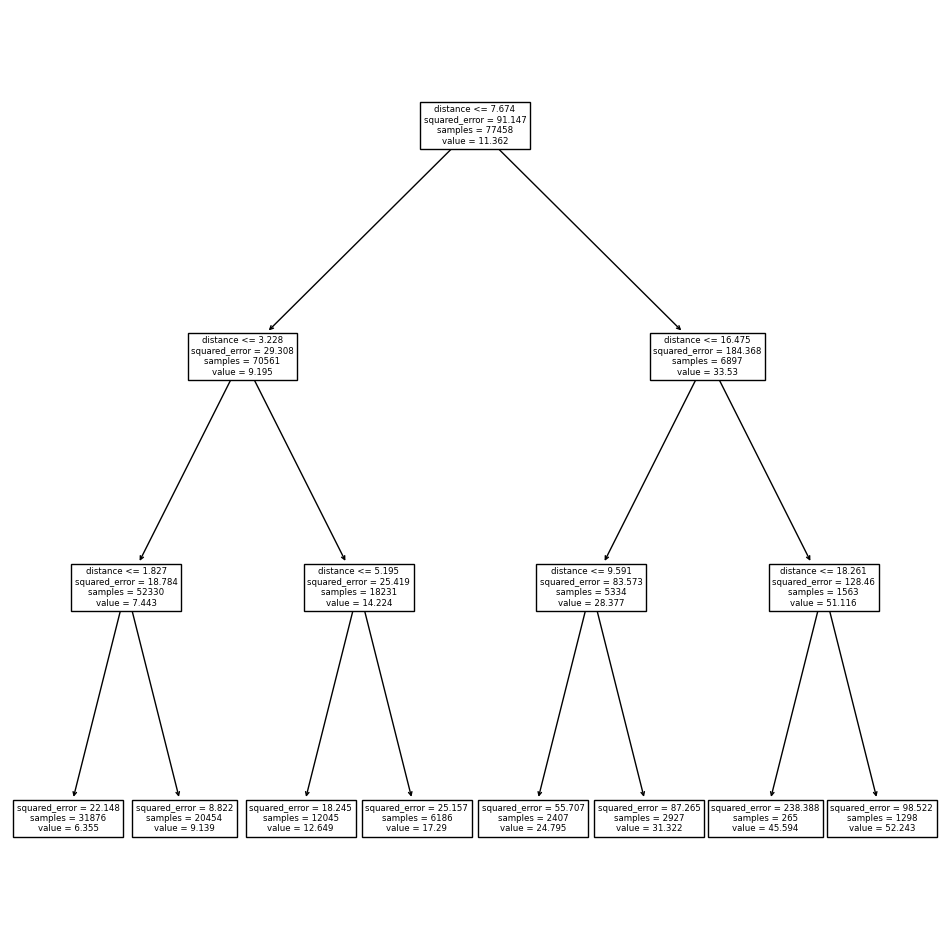

In [9]:
reg = DTR(max_depth=3) # create a decision tree
reg.fit(X_train, y_train) # fit the tree to training data
ax = subplots(figsize=(12,12))[1]
feature_names = list(X.columns) #  extracts the names of the features from X
plot_tree(reg, feature_names=feature_names, ax=ax);# plot the tree


In [10]:
# Make predictions on the test set
y_pred = reg.predict(X_val)

# Evaluate the model's performance on the validation set
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("Validation RMSE (without CV):", rmse)


Validation RMSE (without CV): 4.457240825429301


In [11]:
# computes the cost-complexity pruning path for the decision tree 
#calculates a sequence of best subtrees by pruning the decision tree based
#on different values of the complexity parameter alpha (ccp_alpha). 
#function cost_complexity_pruning_path() returns the effective alphas of subtrees during pruning. 
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train) 
# Cross-validated grid search
# cross-validated grid search for the best value of ccp_alpha
kfold = skm.KFold(5, shuffle=True, random_state=10)
grid = skm.GridSearchCV(reg, {'ccp_alpha': ccp_path.ccp_alphas}, refit=True, cv=kfold,
                            scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)

best_ = grid.best_estimator_
#np.mean((y_test - best_.predict(X_test))**2)
rmse_val = np.sqrt(mean_squared_error(y_val, best_.predict(X_val)))
print("Validation RMSE (with CV):", rmse_val)
print("The best value for max_depth using cv", best_)


Validation RMSE (with CV): 4.457240825429301
The best value for max_depth using cv DecisionTreeRegressor(max_depth=3)


In [12]:
# Once satisfied with the model's performance, train the model on the entire original training set
best_.fit(X, y)


DecisionTreeRegressor(max_depth=3)

In [13]:
# load test data
test = pd.read_csv('../input/new-york-city-taxi-fare-prediction/test.csv')
test.shape


(9914, 7)

In [14]:
# Feature Engineering for the training set
test['distance'] = haversine_distance(test['pickup_latitude'], test['pickup_longitude'], test['dropoff_latitude'], test['dropoff_longitude'])
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])
test['day_of_week'] = test['pickup_datetime'].dt.dayofweek
test['month'] = test['pickup_datetime'].dt.month
test['hour'] = test['pickup_datetime'].dt.hour

# Define features for the test set
X_test = test[['passenger_count','distance', 'day_of_week', 'month', 'hour']]

# Make predictions on the test set
y_pred_test = best_.predict(X_test)
# Add the predictions to the test dataframe
test['fare_amount'] = y_pred_test

submission = pd.DataFrame(
    {'key': test['key'], 'fare_amount': test['fare_amount']},
    columns = ['key', 'fare_amount'])

# save the predictions to a CSV file
submission.to_csv('submission.csv', index = False)
